# Task 3: Interpret the Embedding Space



In [1]:
# Ensure repo root is on sys.path for `utils` imports
from pathlib import Path
import sys
repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Added to sys.path:', repo_root)


Added to sys.path: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer


In [2]:
import os
os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd

from utils.metrics import (
    centroid, delta_to_healthy, wasserstein1d_along_pc, knn_overlap_fraction,
    silhouette_scores_by_label, composite_score
)
from utils.plotting import umap_2d, plot_umap, plot_centroid_shifts

# Use absolute paths matching Task 2 outputs
EMB_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/embeddings')
FIG_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs')
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load embeddings saved in Task 2
healthy_path = EMB_DIR / 'healthy_base.npz'
als_path = EMB_DIR / 'als_base.npz'
if not (healthy_path.exists() and als_path.exists()):
    raise FileNotFoundError("Missing healthy_base.npz or als_base.npz. Run notebook 02 first.")

healthy = np.load(healthy_path)['arr']
als = np.load(als_path)['arr']

# Load perturbation embeddings (both directions for each cohort)
healthy_perts = {}
for p in sorted(EMB_DIR.glob('healthy_*.npz')):
    healthy_perts[p.stem.replace('healthy_', '')] = np.load(p)['arr']
als_perts = {}
for p in sorted(EMB_DIR.glob('als_*.npz')):
    als_perts[p.stem.replace('als_', '')] = np.load(p)['arr']

# Metrics (ALS perts: improvement toward healthy; Healthy perts: distance away)
rows = []
# ALS → evaluate improvement (negative delta_to_healthy = better)
for name, emb_als_pert in als_perts.items():
    d_health = delta_to_healthy(als, emb_als_pert, healthy)
    w1d_before = wasserstein1d_along_pc(als, healthy)
    w1d_after = wasserstein1d_along_pc(emb_als_pert, healthy)
    knn_gain = knn_overlap_fraction(healthy, emb_als_pert, k=15) - knn_overlap_fraction(healthy, als, k=15)
    sil_before = silhouette_scores_by_label(np.vstack([healthy, als]), ['healthy']*len(healthy)+['als']*len(als))
    sil_after = silhouette_scores_by_label(np.vstack([healthy, emb_als_pert]), ['healthy']*len(healthy)+['als_pert']*len(emb_als_pert))
    rows.append({
        'set': 'ALS_perts',
        'perturbation': name,
        'delta_to_healthy': d_health,
        'improvement_toward_healthy': -d_health,
        'wasserstein_before': w1d_before,
        'wasserstein_after': w1d_after,
        'knn_overlap_gain': knn_gain,
        'silhouette_before': sil_before,
        'silhouette_after': sil_after,
    })

# Healthy → evaluate distance from healthy (positive = farther)
for name, emb_h_pert in healthy_perts.items():
    d_from_healthy = delta_to_healthy(healthy, emb_h_pert, healthy)  # positive = moved away
    w1d_before = 0.0  # W(healthy, healthy) = 0
    w1d_after = wasserstein1d_along_pc(healthy, emb_h_pert)
    knn_gain = knn_overlap_fraction(healthy, emb_h_pert, k=15) - knn_overlap_fraction(healthy, healthy, k=15)
    sil_before = 0.0
    sil_after = silhouette_scores_by_label(np.vstack([healthy, emb_h_pert]), ['healthy']*len(healthy)+['healthy_pert']*len(emb_h_pert))
    rows.append({
        'set': 'Healthy_perts',
        'perturbation': name,
        'delta_from_healthy': d_from_healthy,
        'wasserstein_before': w1d_before,
        'wasserstein_after': w1d_after,
        'knn_overlap_gain': knn_gain,
        'silhouette_before': sil_before,
        'silhouette_after': sil_after,
    })

metrics_df = pd.DataFrame(rows)
metrics_df.to_csv(FIG_DIR / 'task3_metrics.csv', index=False)

print("✓ Metrics computed and saved to:", FIG_DIR / 'task3_metrics.csv')


/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/.venv-gf310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Metrics computed and saved to: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs/task3_metrics.csv


/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/.venv-gf310/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


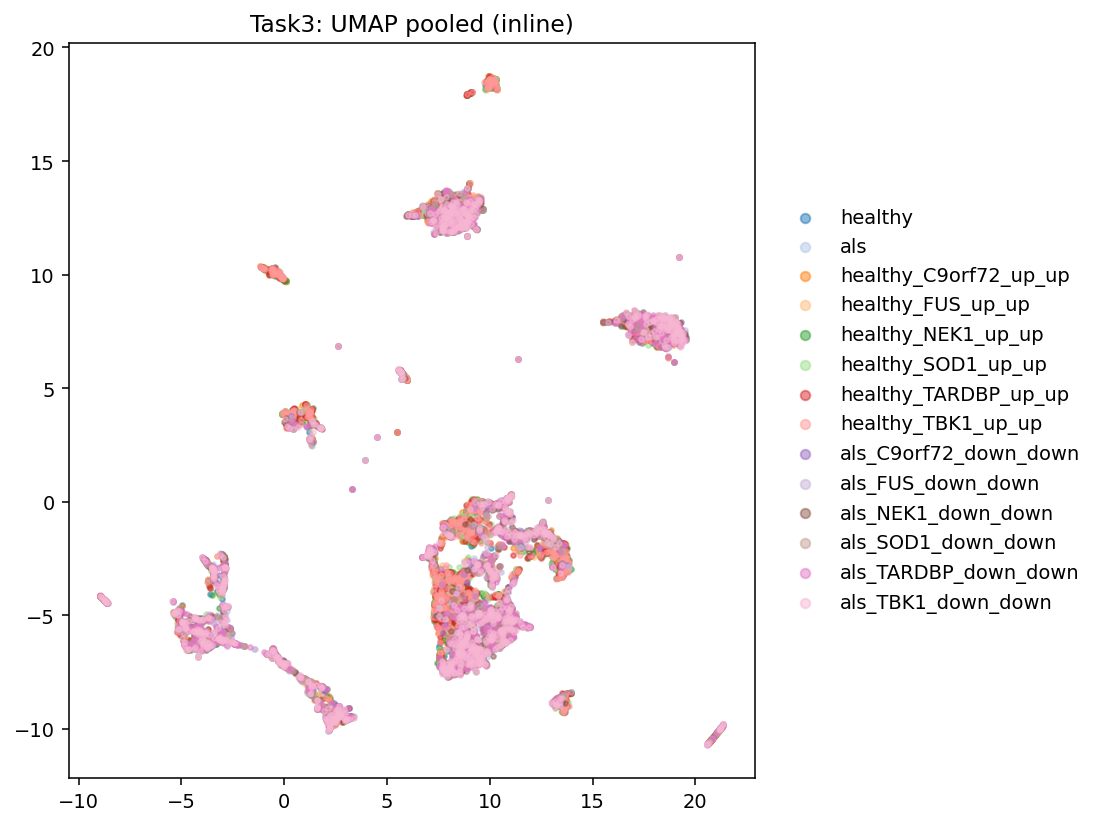

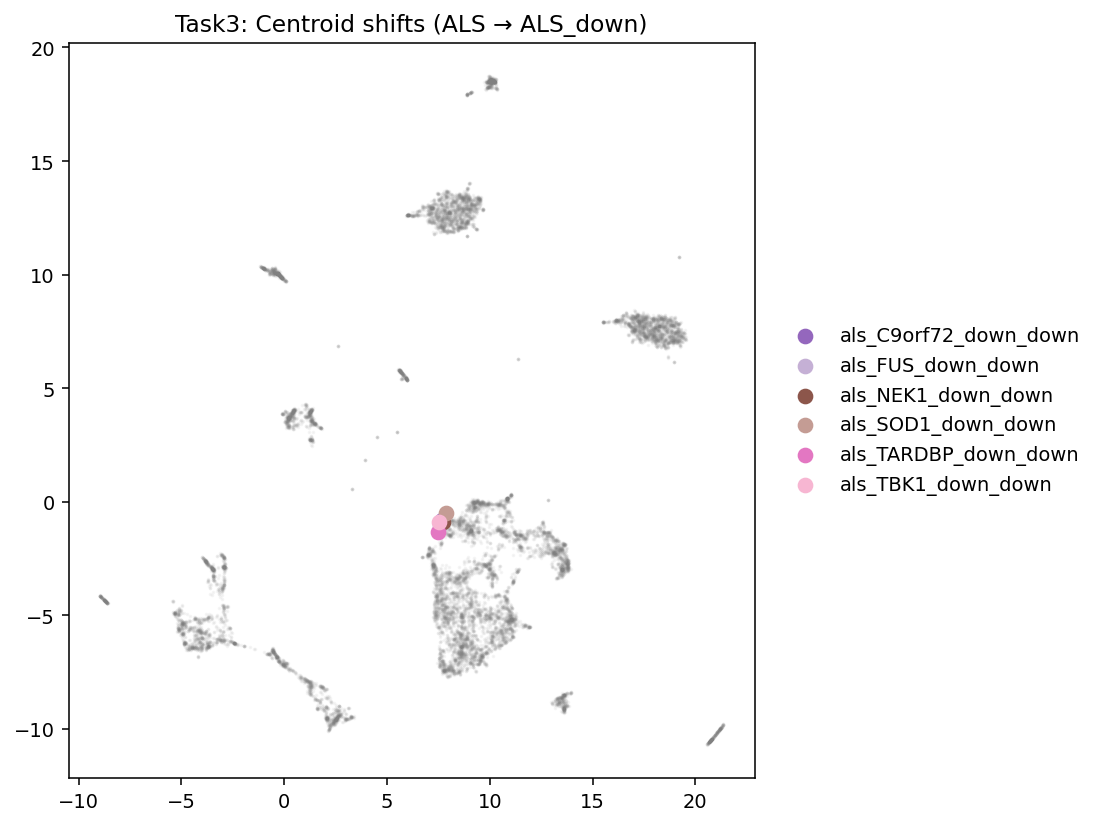

ALS_down (rescue) — best improvement toward healthy:


,perturbation,improvement_toward_healthy,delta_to_healthy,wasserstein_before,wasserstein_after,knn_overlap_gain,silhouette_before,silhouette_after
5,TBK1_down,0.0002,-0.0002,0.6639,0.6646,0.0000,0.0220,0.0220
0,C9orf72_down,0.0000,-0.0000,0.6639,0.6637,-0.0000,0.0220,0.0220
2,NEK1_down,-0.0000,0.0000,0.6639,0.6639,-0.0000,0.0220,0.0220
4,TARDBP_down,-0.0001,0.0001,0.6639,0.6638,0.0000,0.0220,0.0220
3,SOD1_down,-0.0019,0.0019,0.6639,0.6675,-0.0001,0.0220,0.0222
1,FUS_down,-0.0024,0.0024,0.6639,0.6645,0.0000,0.0220,0.0222



Healthy_up (disease-like) — farthest from healthy:


,perturbation,delta_from_healthy,wasserstein_after,knn_overlap_gain,silhouette_after
10,TARDBP_up,-0.0081,0.0157,-0.0829,-0.0001
7,FUS_up,-0.0166,0.0315,-0.2650,0.0008
9,SOD1_up,-0.0208,0.0405,-0.2769,0.0015
11,TBK1_up,-0.0221,0.0314,-0.1372,0.0002
6,C9orf72_up,-0.0230,0.0294,-0.1350,0.0002
8,NEK1_up,-0.0302,0.0318,-0.3055,0.0013


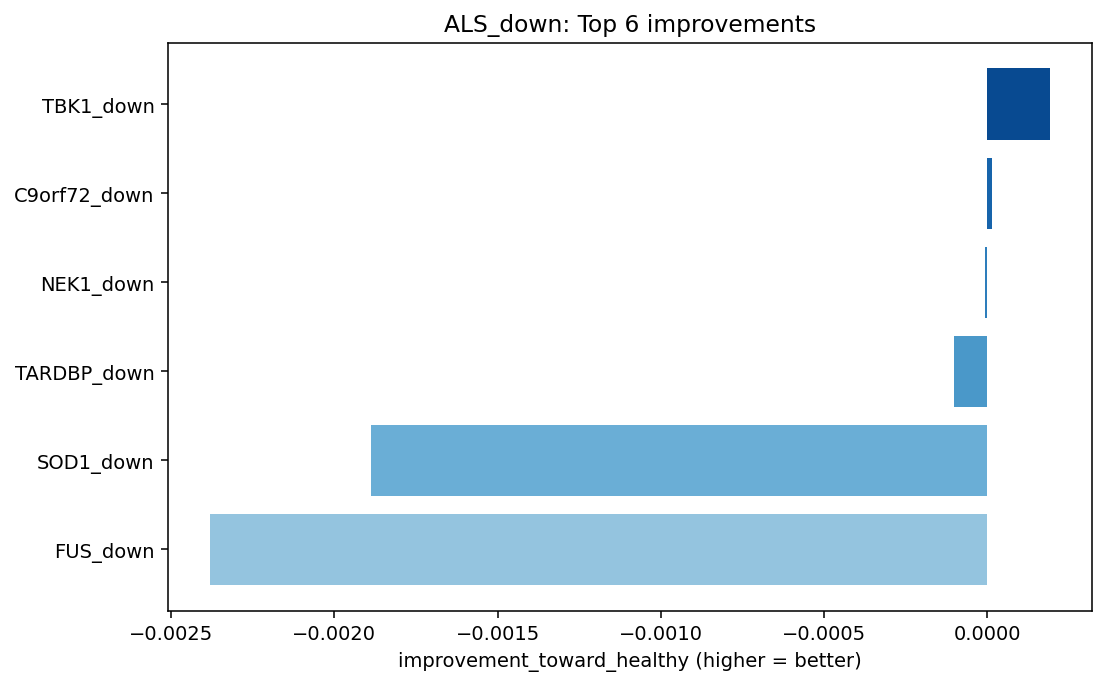

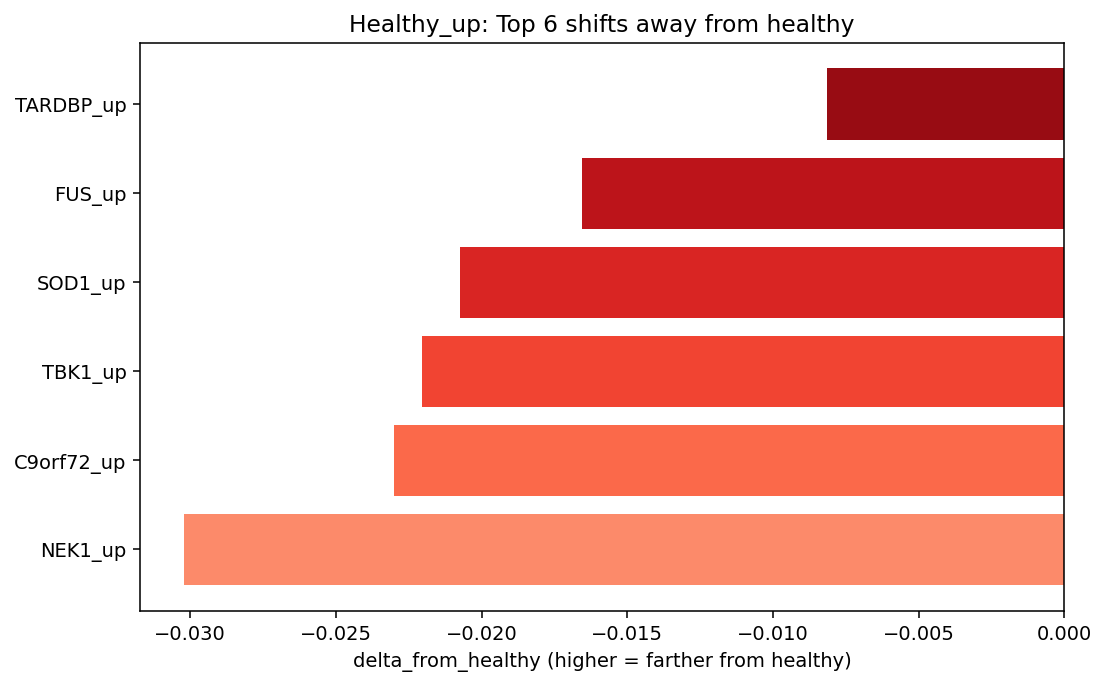

In [ ]:
# Inline interpretation with healthy_up / als_down
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) UMAP pooled (recompute from already-loaded arrays)
pool = [healthy, als] + list(healthy_perts.values()) + list(als_perts.values())
labels = (['healthy'] * len(healthy) +
          ['als'] * len(als) +
          sum([[f'healthy_{k}'] * len(v) for k, v in healthy_perts.items()], []) +
          sum([[f'als_{k}'] * len(v) for k, v in als_perts.items()], []))
X = np.vstack(pool)
# Downsample per label for faster UMAP
MAX_PER_LABEL = 1000
rng = np.random.default_rng(0)
label_arr = np.array(labels)
keep_idx = []
for c in np.unique(label_arr):
    idx = np.where(label_arr == c)[0]
    if len(idx) > MAX_PER_LABEL:
        sel = rng.choice(idx, size=MAX_PER_LABEL, replace=False)
    else:
        sel = idx
    keep_idx.append(sel)
keep_idx = np.concatenate(keep_idx)
X = X[keep_idx]
label_arr = label_arr[keep_idx]
labels = label_arr.tolist()
pts = umap_2d(X, n_neighbors=10)

categories = (['healthy', 'als'] +
              [f'healthy_{k}' for k in sorted(healthy_perts.keys())] +
              [f'als_{k}' for k in sorted(als_perts.keys())])
palette = {c: plt.cm.tab20(i % 20) for i, c in enumerate(categories)}
label_arr = np.array(labels)

plt.figure(figsize=(8, 6), dpi=140)
for c in categories:
    m = (label_arr == c)
    if m.any():
        plt.scatter(pts[m, 0], pts[m, 1], s=6, alpha=0.5, c=[palette[c]], label=c)
plt.title('Task3: UMAP pooled (inline)')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, markerscale=2)
plt.tight_layout()
plt.show()

# 2) Centroid shifts (ALS baseline → ALS_down)
plt.figure(figsize=(8, 6), dpi=140)
plt.scatter(pts[:, 0], pts[:, 1], s=1, alpha=0.06, color='gray')
cent_als = pts[label_arr == 'als'].mean(axis=0)
for k in sorted(als_down.keys()):
    tag = f'als_{k}_down'
    m = (label_arr == tag)
    if m.any():
        c = pts[m].mean(axis=0)
        plt.scatter(c[0], c[1], s=50, c=[palette[tag]], label=tag)
plt.title('Task3: Centroid shifts (ALS → ALS_down)')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.show()

# 3) Metrics — show ALS (all directions) and Healthy (all directions)
als_df = metrics_df[metrics_df['set'] == 'ALS_perts'].copy()
als_df = als_df.sort_values('improvement_toward_healthy', ascending=False)
healthy_df = metrics_df[metrics_df['set'] == 'Healthy_perts'].copy()
healthy_df = healthy_df.sort_values('delta_from_healthy', ascending=False)

print('ALS perturbations — best improvement toward healthy:')
display(als_df[['perturbation','improvement_toward_healthy','delta_to_healthy','wasserstein_before','wasserstein_after','knn_overlap_gain','silhouette_before','silhouette_after']]
       .style.format({'improvement_toward_healthy':'{:.4f}','delta_to_healthy':'{:.4f}','wasserstein_before':'{:.4f}','wasserstein_after':'{:.4f}','knn_overlap_gain':'{:.4f}','silhouette_before':'{:.4f}','silhouette_after':'{:.4f}'}))

print('\nHealthy perturbations — farthest from healthy:')
display(healthy_df[['perturbation','delta_from_healthy','wasserstein_after','knn_overlap_gain','silhouette_after']]
       .style.format({'delta_from_healthy':'{:.4f}','wasserstein_after':'{:.4f}','knn_overlap_gain':'{:.4f}','silhouette_after':'{:.4f}'}))

# Bar plots
top_k = 6
plt.figure(figsize=(8, 5), dpi=140)
subset = als_df.head(top_k)
plt.barh(subset['perturbation'][::-1], subset['improvement_toward_healthy'][::-1], color=plt.cm.Blues(np.linspace(0.4, 0.9, len(subset))))
plt.xlabel('improvement_toward_healthy (higher = better)')
plt.title(f'ALS perts: Top {top_k} improvements')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5), dpi=140)
subset = healthy_df.head(top_k)
plt.barh(subset['perturbation'][::-1], subset['delta_from_healthy'][::-1], color=plt.cm.Reds(np.linspace(0.4, 0.9, len(subset))))
plt.xlabel('delta_from_healthy (higher = farther from healthy)')
plt.title(f'Healthy perts: Top {top_k} shifts away from healthy')
plt.tight_layout()
plt.show()

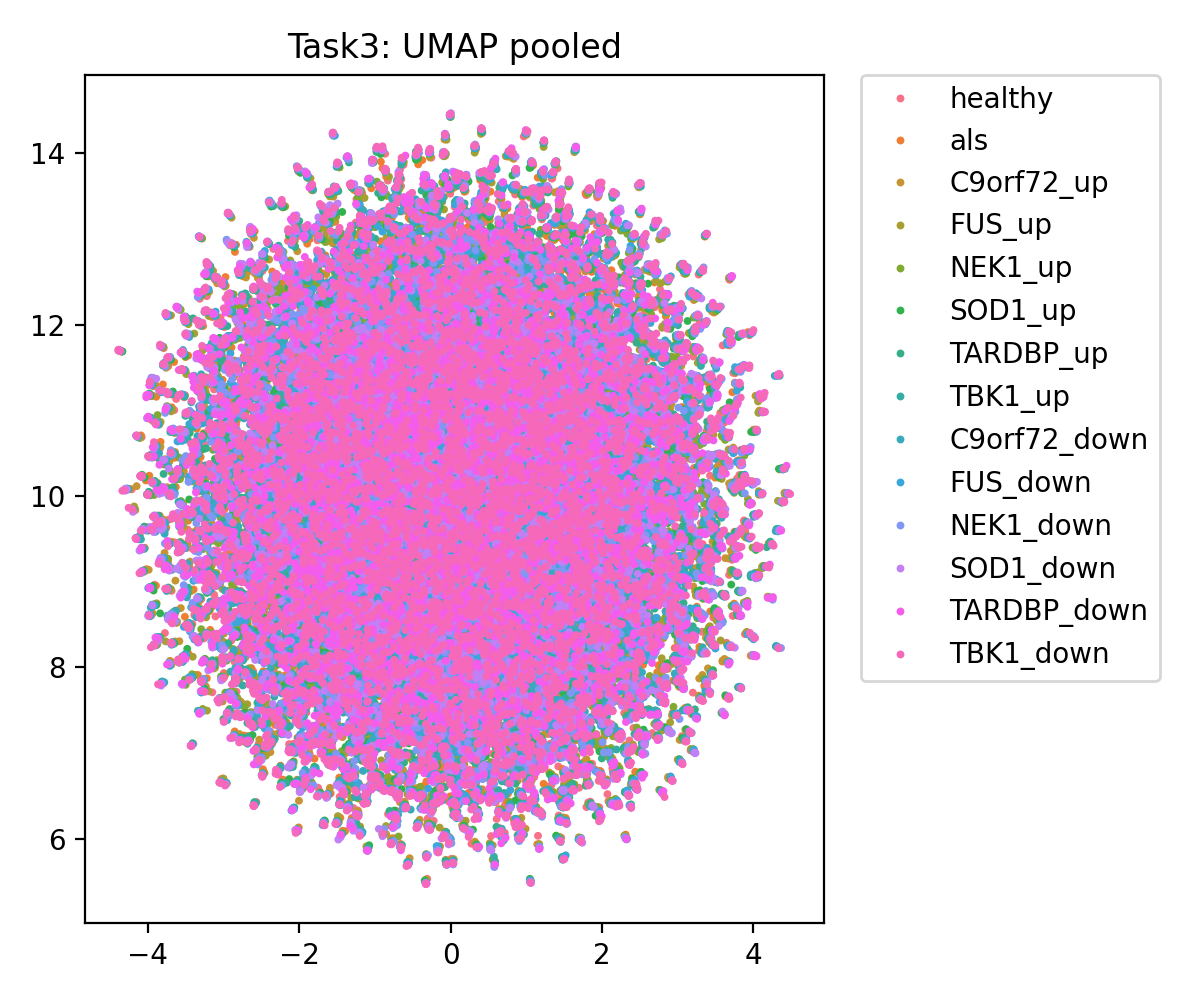

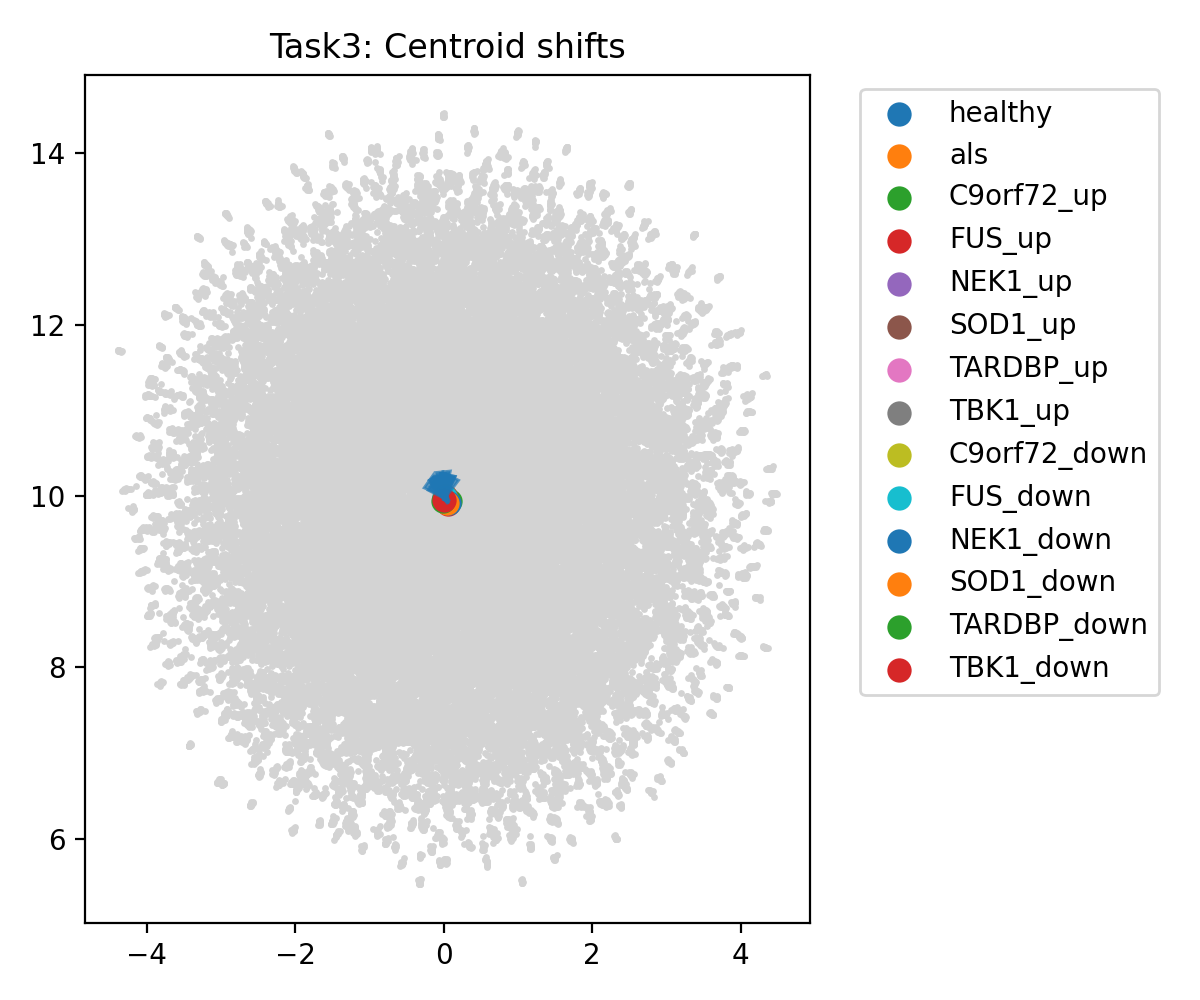


Top perturbations by delta_to_healthy:


,set,perturbation,delta_to_healthy,improvement_toward_healthy,wasserstein_before,wasserstein_after,knn_overlap_gain,silhouette_before,silhouette_after,delta_from_healthy
1,ALS_down,FUS_down,0.002381,-0.002381,0.663916,0.664520,0.000007,0.022031,0.022151,NaN
3,ALS_down,SOD1_down,0.001888,-0.001888,0.663916,0.667492,-0.000054,0.022031,0.022168,NaN
4,ALS_down,TARDBP_down,0.000102,-0.000102,0.663916,0.663842,0.000000,0.022031,0.022034,NaN
2,ALS_down,NEK1_down,0.000008,-0.000008,0.663916,0.663863,-0.000007,0.022031,0.022006,NaN
0,ALS_down,C9orf72_down,-0.000015,0.000015,0.663916,0.663682,-0.000007,0.022031,0.022043,NaN
5,ALS_down,TBK1_down,-0.000193,0.000193,0.663916,0.664576,0.000008,0.022031,0.022032,NaN
6,Healthy_up,C9orf72_up,NaN,NaN,0.000000,0.029420,-0.135023,0.000000,0.000178,-0.023024
7,Healthy_up,FUS_up,NaN,NaN,0.000000,0.031467,-0.264980,0.000000,0.000850,-0.016555
8,Healthy_up,NEK1_up,NaN,NaN,0.000000,0.031779,-0.305475,0.000000,0.001256,-0.030213
9,Healthy_up,SOD1_up,NaN,NaN,0.000000,0.040512,-0.276928,0.000000,0.001492,-0.020750


In [6]:
# Display saved figures and metrics
from IPython.display import Image, display

# Show saved UMAP plot
umap_path = FIG_DIR / 'task3_umap.png'
if umap_path.exists():
    display(Image(str(umap_path)))
else:
    print("UMAP plot not found")

# Show saved centroid shifts plot
cent_path = FIG_DIR / 'task3_centroid_shifts.png'
if cent_path.exists():
    display(Image(str(cent_path)))
else:
    print("Centroid shifts plot not found")

# Display metrics table sorted by delta_to_healthy
print("\nTop perturbations by delta_to_healthy:")
display(metrics_df.sort_values('delta_to_healthy', ascending=False))

